## Set-up


In [36]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from helper import *
import math

import cv2
from PIL import Image
from scipy.ndimage import binary_dilation, binary_erosion

from pymatting import cutout


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
def random_color():
    # Generate random values for red, green, and blue
    r, g, b = [random.randint(0, 255) for i in range(3)]
    # Create a numpy array with the random RGB values and fixed alpha value of 255
    color = np.array([r, g, b, 255], dtype=np.uint8)
    return color

# print(color)  # prints something like [112  43 194 255]


In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


## Example image


In [45]:
image_path = 'images/gawang.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


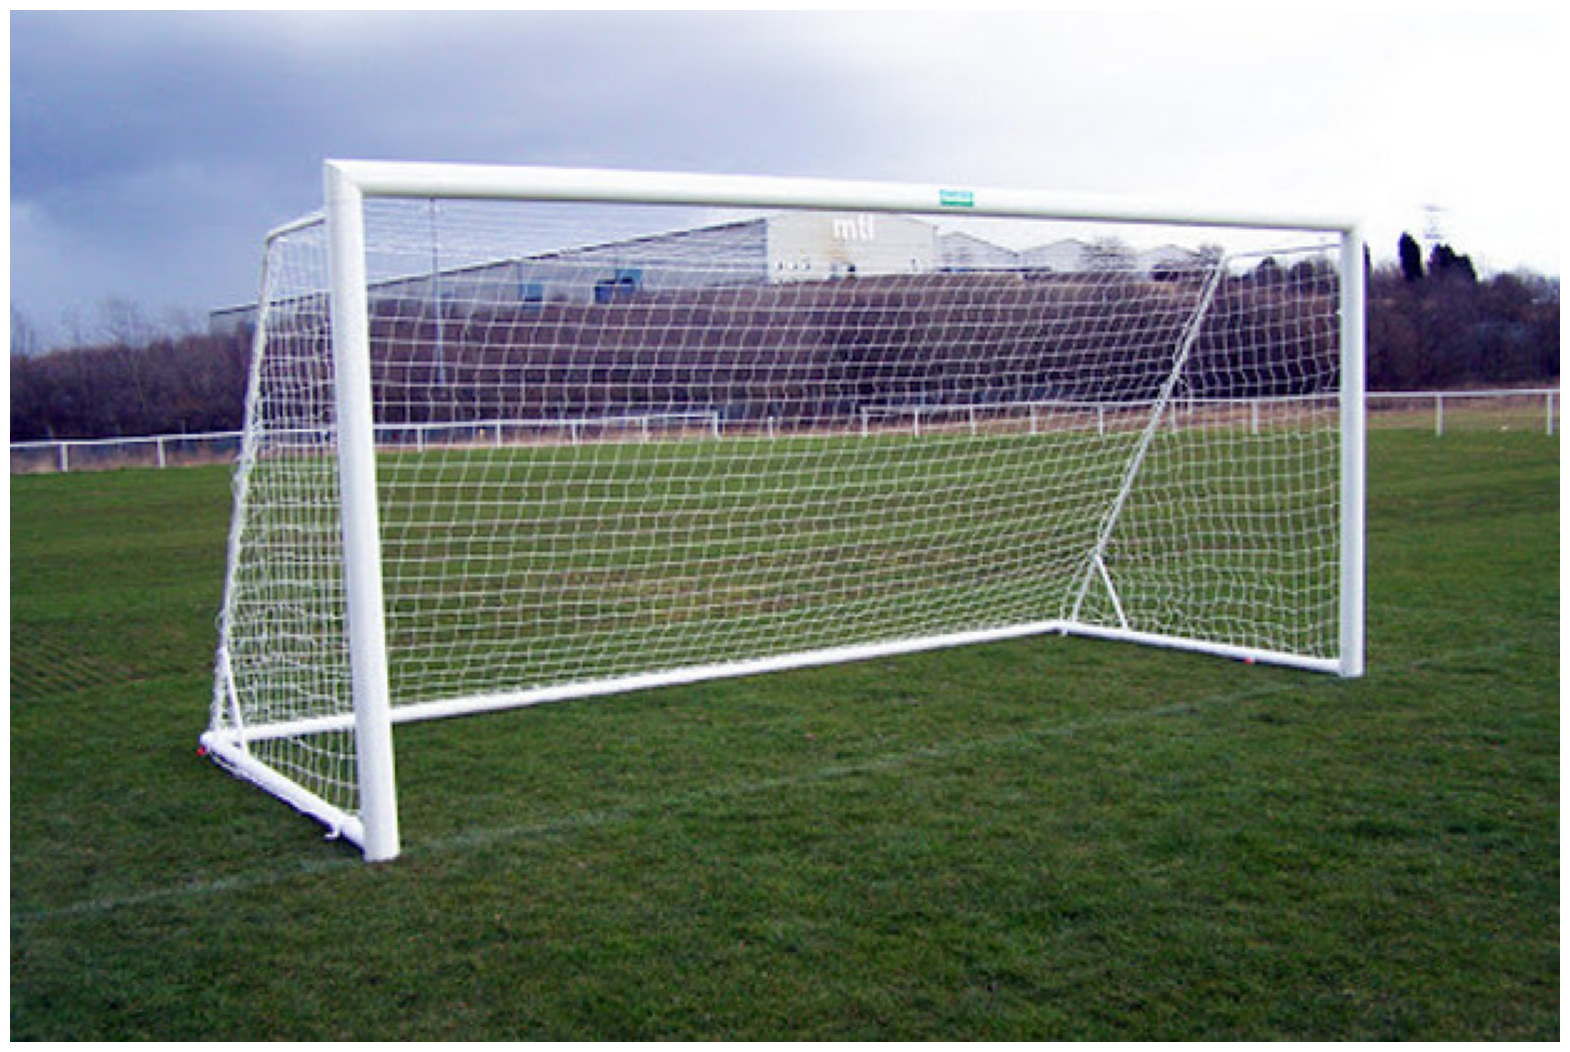

In [46]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()


## Automatic mask generation


To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.


In [47]:
import sys
# sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/Users/susanto/Documents/Proyek/best-remove-background/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

# print(mask_generator)


To generate masks, just run `generate` on an image.


In [49]:
masks = mask_generator.generate(image)


Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

- `segmentation` : the mask
- `area` : the area of the mask in pixels
- `bbox` : the boundary box of the mask in XYWH format
- `predicted_iou` : the model's own prediction for the quality of the mask
- `point_coords` : the sampled input point that generated this mask
- `stability_score` : an additional measure of mask quality
- `crop_box` : the crop of the image used to generate this mask in XYWH format


In [50]:
print(len(masks))
print(masks[0].keys())


27
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [51]:
# RGB numpy array to RGBA numpy array
rgba_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
rgba_image[:, :, :3] = image
rgba_image[:, :, 3] = 255


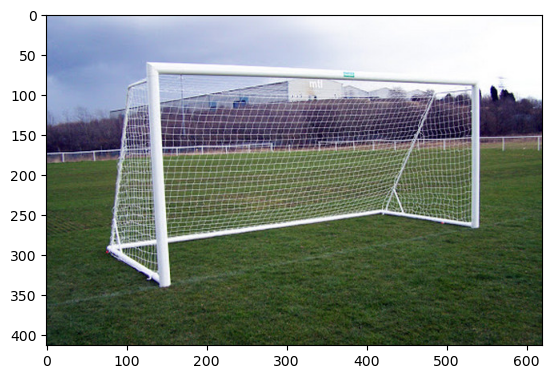

In [52]:
plt.imshow(rgba_image)


In [53]:
# # Make blank image with same size
# base_img = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)


In [54]:


sys.path.append(
    '/Users/susanto/Documents/Proyek/best-remove-background/latihan-remove-background/PytorchSuccessExample/algorithm/clustering')


sys.path.append(
    '/Users/susanto/Documents/Proyek/best-remove-background/latihan-remove-background/PytorchSuccessExample/algorithm/filter')



from filter import dominantTransparent, detect_dominant_color, dominant_transparent_rgba, detect_dominant_color_rgba,color_diff_rgba
from clustering import getMasksColorCluster

In [55]:
def get_edge_mask(mask):
    # Dilate the mask to get the boundary pixels
    dilated_mask = binary_dilation(mask)
    # Erode the mask to get the interior pixels
    eroded_mask = binary_erosion(mask)
    # Subtract the eroded mask from the dilated mask to get the boundary pixels
    edge_mask = np.logical_and(dilated_mask, np.logical_not(eroded_mask))
    return edge_mask


In [56]:
print(type(image))

print(rgba_image.shape)


<class 'numpy.ndarray'>
(413, 620, 4)


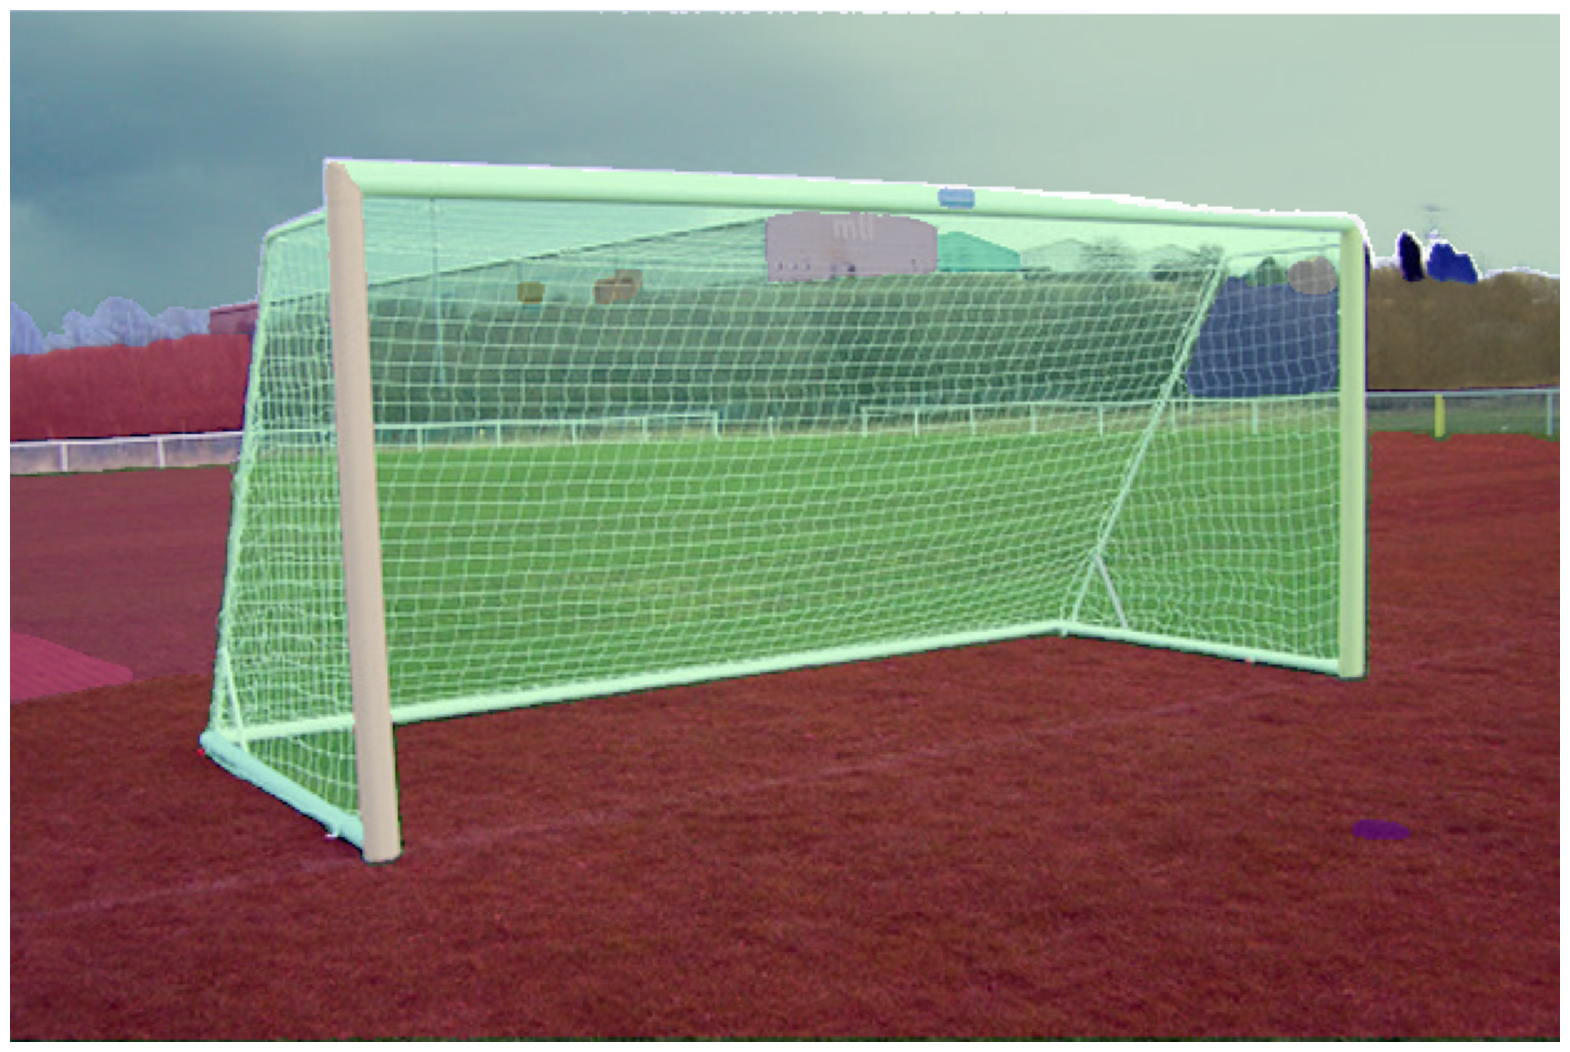

In [57]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()


In [58]:
len(masks)

27

In [59]:
x = masks[0]["segmentation"]

mask = x.astype(np.uint8) * 255

# plt.imshow(mask)
print(mask)

[[  0   0   0 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [63]:
# Convert new masks
index = 0

for a in masks:
    x = a["segmentation"]
    mask = x.astype(np.uint8) * 255

    # Dilate the mask
    kernel = np.ones((5, 5), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=4)

    # Erode the mask
    eroded_mask = cv2.erode(mask, kernel, iterations=2)

    # Create the trimap
    trimap = np.zeros_like(mask)
    trimap[mask == 255] = 255 # Set foreground
    trimap[dilated_mask - mask == 255] = 127 # Set transition
    # trimap[eroded_mask == 0] = 0 # Set background

    m = rgba_image.copy()
    m[x==False] = [0,0,0,0]
    PIL_image= Image.fromarray(m)
    PIL_image.save('output/'+str(index)+"_origin.png")

    PIL_image= Image.fromarray(trimap)
    PIL_image.save('output/'+str(index)+"_trimap.png")

    index+=1


In [62]:
index = 0

for a in masks:
    cutout(
        # input image path
        "images/gawang.jpg",
        # input trimap path
        "output/"+str(index)+"_trimap.png",
        # output cutout path
        "output/parts/"+str(index)+"_trimap.png")
    index+=1